<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 4515, '日付': '2021-08-06T08:00:00.000Z'},
 {'小計': 4566, '日付': '2021-08-07T08:00:00.000Z'},
 {'小計': 4066, '日付': '2021-08-08T08:00:00.000Z'},
 {'小計': 2884, '日付': '2021-08-09T08:00:00.000Z'},
 {'小計': 2612, '日付': '2021-08-10T08:00:00.000Z'},
 {'小計': 4200, '日付': '2021-08-11T08:00:00.000Z'},
 {'小計': 4989, '日付': '2021-08-12T08:00:00.000Z'},
 {'小計': 5773, '日付': '2021-08-13T08:00:00.000Z'},
 {'小計': 5094, '日付': '2021-08-14T08:00:00.000Z'},
 {'小計': 4295, '日付': '2021-08-15T08:00:00.000Z'},
 {'小計': 2962, '日付': '2021-08-16T08:00:00.000Z'},
 {'小計': 4377, '日付': '2021-08-17T08:00:00.000Z'},
 {'小計': 5386, '日付': '2021-08-18T08:00:00.000Z'},
 {'小計': 5534, '日付': '2021-08-19T08:00:00.000Z'},
 {'小計': 5405, '日付': '2021-08-20T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-08-16 17:00:00+09:00,1740,0,2962,2021-08-16 17:00:00+09:00
2021-08-17 17:00:00+09:00,1775,0,4377,2021-08-17 17:00:00+09:00
2021-08-18 17:00:00+09:00,1682,0,5386,2021-08-18 17:00:00+09:00
2021-08-19 17:00:00+09:00,1610,0,5534,2021-08-19 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-08-16 17:00:00+09:00,1740,0,2962,2021-08-16 17:00:00+09:00,1823.000000,12761.0,0.0,0.0,4275.000000,29925.0
2021-08-17 17:00:00+09:00,1775,0,4377,2021-08-17 17:00:00+09:00,1798.000000,12586.0,0.0,0.0,4527.142857,31690.0
2021-08-18 17:00:00+09:00,1682,0,5386,2021-08-18 17:00:00+09:00,1798.000000,12586.0,0.0,0.0,4696.571429,32876.0
2021-08-19 17:00:00+09:00,1610,0,5534,2021-08-19 17:00:00+09:00,1761.571429,12331.0,0.0,0.0,4774.428571,33421.0
2021-08-20 17:00:00+09:00,0,0,5405,2021-08-20 17:00:00+09:00,1512.000000,10584.0,0.0,0.0,4721.857143,33053.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-08-06 17:00:00+09:00,1560,0,4515,2021-08-06 17:00:00+09:00,1537.714286,10764.0,0.0,0.0,3820.428571,26743.0,'21w31,Fri
2021-08-07 17:00:00+09:00,2038,0,4566,2021-08-07 17:00:00+09:00,1596.142857,11173.0,0.0,0.0,3893.000000,27251.0,'21w31,Sat
2021-08-08 17:00:00+09:00,1991,0,4066,2021-08-08 17:00:00+09:00,1662.285714,11636.0,0.0,0.0,4037.000000,28259.0,'21w31,Sun
2021-08-09 17:00:00+09:00,1878,0,2884,2021-08-09 17:00:00+09:00,1702.857143,11920.0,0.0,0.0,4135.428571,28948.0,'21w32,Mon
2021-08-10 17:00:00+09:00,1950,0,2612,2021-08-10 17:00:00+09:00,1783.714286,12486.0,0.0,0.0,3978.714286,27851.0,'21w32,Tue
2021-08-11 17:00:00+09:00,1682,0,4200,2021-08-11 17:00:00+09:00,1803.857143,12627.0,0.0,0.0,3983.571429,27885.0,'21w32,Wed
2021-08-12 17:00:00+09:00,1865,0,4989,2021-08-12 17:00:00+09:00,1852.000000,12964.0,0.0,0.0,3976.000000,27832.0,'21w32,Thu
2021-08-13 17:00:00+09:00,1747,0,5773,2021-08-13 17:00:00+09:00,1878.714286,13151.0,0.0,0.0,4155.714286,29090.0,'21w32,Fri
2021-08-14 17:00:00+09:00,2061,0,5094,2021-08-14 17:00:00+09:00,1882.000000,13174.0,0.0,0.0,4231.142857,29618.0,'21w32,Sat
2021-08-15 17:00:00+09:00,1716,0,4295,2021-08-15 17:00:00+09:00,1842.714286,12899.0,0.0,0.0,4263.857143,29847.0,'21w32,Sun


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-08-01 17:00:00+09:00,3105.000000,21735
2021-08-08 17:00:00+09:00,4037.000000,28259
2021-08-15 17:00:00+09:00,4263.857143,29847
2021-08-20 17:00:00+09:00,4732.800000,23664
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-08-06 17:00:00+09:00,1560,0,4515,2021-08-06 17:00:00+09:00,1537.714286,10764.0,0.0,0.0,3820.428571,26743.0,'21w31,Fri,NaN,NaN
2021-08-07 17:00:00+09:00,2038,0,4566,2021-08-07 17:00:00+09:00,1596.142857,11173.0,0.0,0.0,3893.000000,27251.0,'21w31,Sat,NaN,NaN
2021-08-08 17:00:00+09:00,1991,0,4066,2021-08-08 17:00:00+09:00,1662.285714,11636.0,0.0,0.0,4037.000000,28259.0,'21w31,Sun,4037.000000,28259.0
2021-08-09 17:00:00+09:00,1878,0,2884,2021-08-09 17:00:00+09:00,1702.857143,11920.0,0.0,0.0,4135.428571,28948.0,'21w32,Mon,NaN,NaN
2021-08-10 17:00:00+09:00,1950,0,2612,2021-08-10 17:00:00+09:00,1783.714286,12486.0,0.0,0.0,3978.714286,27851.0,'21w32,Tue,NaN,NaN
2021-08-11 17:00:00+09:00,1682,0,4200,2021-08-11 17:00:00+09:00,1803.857143,12627.0,0.0,0.0,3983.571429,27885.0,'21w32,Wed,NaN,NaN
2021-08-12 17:00:00+09:00,1865,0,4989,2021-08-12 17:00:00+09:00,1852.000000,12964.0,0.0,0.0,3976.000000,27832.0,'21w32,Thu,NaN,NaN
2021-08-13 17:00:00+09:00,1747,0,5773,2021-08-13 17:00:00+09:00,1878.714286,13151.0,0.0,0.0,4155.714286,29090.0,'21w32,Fri,NaN,NaN
2021-08-14 17:00:00+09:00,2061,0,5094,2021-08-14 17:00:00+09:00,1882.000000,13174.0,0.0,0.0,4231.142857,29618.0,'21w32,Sat,NaN,NaN
2021-08-15 17:00:00+09:00,1716,0,4295,2021-08-15 17:00:00+09:00,1842.714286,12899.0,0.0,0.0,4263.857143,29847.0,'21w32,Sun,4263.857143,29847.0


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

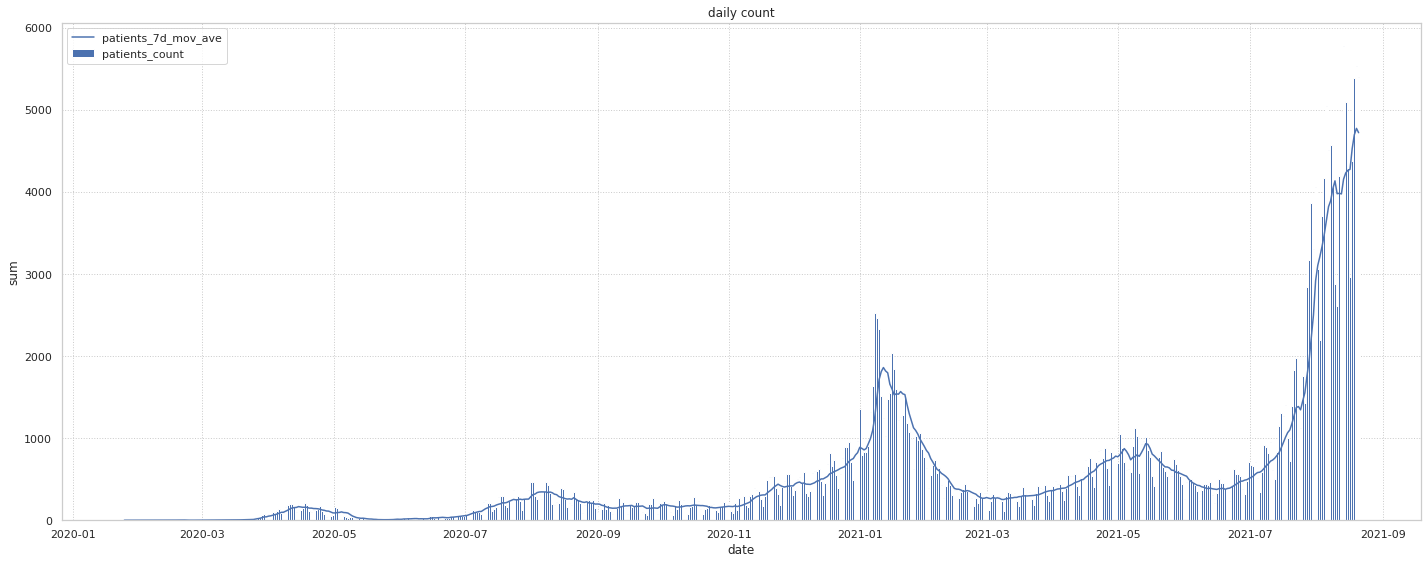

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
560,1.628237e+09,2021,8,6,1,0,0,0,0,0,0,560,0,486,1560,1537.714286,10764.0,0,0.0,0.0,4515,3820.428571,26743.0
561,1.628323e+09,2021,8,7,0,0,1,0,0,0,0,561,0,487,2038,1596.142857,11173.0,0,0.0,0.0,4566,3893.000000,27251.0
562,1.628410e+09,2021,8,8,0,0,0,1,0,0,0,562,0,488,1991,1662.285714,11636.0,0,0.0,0.0,4066,4037.000000,28259.0
563,1.628496e+09,2021,8,9,0,1,0,0,0,0,0,563,0,489,1878,1702.857143,11920.0,0,0.0,0.0,2884,4135.428571,28948.0
564,1.628582e+09,2021,8,10,0,0,0,0,0,1,0,564,0,490,1950,1783.714286,12486.0,0,0.0,0.0,2612,3978.714286,27851.0
565,1.628669e+09,2021,8,11,0,0,0,0,0,0,1,565,0,491,1682,1803.857143,12627.0,0,0.0,0.0,4200,3983.571429,27885.0
566,1.628755e+09,2021,8,12,0,0,0,0,1,0,0,566,0,492,1865,1852.000000,12964.0,0,0.0,0.0,4989,3976.000000,27832.0
567,1.628842e+09,2021,8,13,1,0,0,0,0,0,0,567,0,493,1747,1878.714286,13151.0,0,0.0,0.0,5773,4155.714286,29090.0
568,1.628928e+09,2021,8,14,0,0,1,0,0,0,0,568,0,494,2061,1882.000000,13174.0,0,0.0,0.0,5094,4231.142857,29618.0
569,1.629014e+09,2021,8,15,0,0,0,1,0,0,0,569,0,495,1716,1842.714286,12899.0,0,0.0,0.0,4295,4263.857143,29847.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            575 non-null    float64
 1   year                 575 non-null    int64  
 2   month                575 non-null    int64  
 3   day                  575 non-null    int64  
 4   Fri                  575 non-null    uint8  
 5   Mon                  575 non-null    uint8  
 6   Sat                  575 non-null    uint8  
 7   Sun                  575 non-null    uint8  
 8   Thu                  575 non-null    uint8  
 9   Tue                  575 non-null    uint8  
 10  Wed                  575 non-null    uint8  
 11  passed               575 non-null    int64  
 12  emergency            575 non-null    int64  
 13  em_passed            575 non-null    int64  
 14  contacts_count       575 non-null    int64  
 15  contacts_7d_mov_ave  575 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.750000e+02,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000
mean,1.604650e+09,2020.403478,5.866087,15.688696,0.144348,0.142609,0.142609,0.142609,0.142609,0.142609,0.142609,287.000000,0.085217,217.826087,691.106087,684.821573,4793.744348,640.902609,640.902609,4486.318261,526.601739,500.520323,3503.613913
std,1.435385e+07,0.491022,3.133134,8.814116,0.351748,0.349978,0.349978,0.349978,0.349978,0.349978,0.349978,166.132477,0.279448,158.987611,462.278301,445.907375,3121.361831,848.650696,768.894408,5382.260856,876.792185,783.181692,5482.289970
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.592251e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.500000,0.000000,69.500000,380.500000,384.642857,2692.500000,0.000000,0.000000,0.000000,90.000000,104.714286,733.000000
50%,1.604650e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,287.000000,0.000000,213.000000,533.000000,550.000000,3850.000000,0.000000,0.000000,0.000000,266.000000,273.142857,1912.000000
75%,1.617048e+09,2021.000000,8.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,430.500000,0.000000,356.500000,805.500000,802.785714,5619.500000,1287.500000,1257.642857,8803.500000,561.500000,564.642857,3952.500000
max,1.629446e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,574.000000,1.000000,500.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5773.000000,4774.428571,33421.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.849737,0.146089,-0.012104,-1.285429e-18,-0.001229,-0.006143,-0.003686,0.006143,0.001229,0.003686,1.000000e+00,-0.347528,0.996863,-0.113723,-0.114456,-0.114452,-0.581985,-0.627275,-0.627275,0.573951,0.596514,0.596520
year,8.497369e-01,1.000000,-0.395138,-0.044190,5.157446e-03,-0.000864,-0.000864,-0.000864,-0.000864,-0.000864,-0.000864,8.497369e-01,-0.251016,0.862937,-0.153430,-0.147416,-0.147414,-0.621639,-0.686120,-0.686120,0.486856,0.517610,0.517613
month,1.460895e-01,-0.395138,1.000000,-0.030279,-1.088416e-02,-0.000030,-0.009563,-0.004797,0.012680,0.004736,0.007914,1.460895e-01,-0.132198,0.115693,0.094717,0.081993,0.081996,0.154571,0.198077,0.198077,0.086719,0.069373,0.069381
day,-1.210449e-02,-0.044190,-0.030279,1.000000,1.283337e-02,-0.004785,0.004816,-0.000267,-0.003656,-0.010433,0.001427,-1.210449e-02,0.000180,-0.011393,-0.035210,-0.034923,-0.034926,0.012395,-0.000223,-0.000223,-0.023962,-0.038687,-0.038692
Fri,-1.285429e-18,0.005157,-0.010884,0.012833,1.000000e+00,-0.167510,-0.167510,-0.167510,-0.167510,-0.167510,-0.167510,2.541987e-18,-0.001295,0.000886,-0.029022,-0.000786,-0.000785,0.028639,-0.003539,-0.003539,0.041977,0.010841,0.010838
Mon,-1.228505e-03,-0.000864,-0.000030,-0.004785,-1.675097e-01,1.000000,-0.166329,-0.166329,-0.166329,-0.166329,-0.166329,-1.228505e-03,0.000217,-0.001276,0.035334,-0.001226,-0.001225,0.127086,0.000593,0.000593,-0.092839,-0.004724,-0.004724
Sat,-6.142525e-03,-0.000864,-0.009563,0.004816,-1.675097e-01,-0.166329,1.000000,-0.166329,-0.166329,-0.166329,-0.166329,-6.142525e-03,0.000217,-0.005722,0.045747,-0.006737,-0.006736,-0.145539,0.000593,0.000593,0.020732,-0.011311,-0.011313
Sun,-3.685515e-03,-0.000864,-0.004797,-0.000267,-1.675097e-01,-0.166329,-0.166329,1.000000,-0.166329,-0.166329,-0.166329,-3.685515e-03,0.000217,-0.003499,-0.022578,-0.004001,-0.004000,-0.134049,0.000593,0.000593,-0.032159,-0.007413,-0.007413
Thu,6.142525e-03,-0.000864,0.012680,-0.003656,-1.675097e-01,-0.166329,-0.166329,-0.166329,1.000000,-0.166329,-0.166329,6.142525e-03,0.000217,0.005456,0.000628,0.006855,0.006856,0.037458,0.000593,0.000593,0.062779,0.009164,0.009166
Tue,1.228505e-03,-0.000864,0.004736,-0.010433,-1.675097e-01,-0.166329,-0.166329,-0.166329,-0.166329,1.000000,-0.166329,1.228505e-03,0.000217,0.000947,-0.021016,0.001605,0.001606,0.051025,0.000593,0.000593,-0.023717,-0.000751,-0.000749


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,1.629101e+09,0,1,0,0,0,0,0,570,0,496,1740,0,2962,4275.000000,29925.0
571,1.629187e+09,0,0,0,0,0,1,0,571,0,497,1775,0,4377,4527.142857,31690.0
572,1.629274e+09,0,0,0,0,0,0,1,572,0,498,1682,0,5386,4696.571429,32876.0
573,1.629360e+09,0,0,0,0,1,0,0,573,0,499,1610,0,5534,4774.428571,33421.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
570,1.629101e+09,570,0,2962,4275.000000,29925.0
571,1.629187e+09,571,0,4377,4527.142857,31690.0
572,1.629274e+09,572,0,5386,4696.571429,32876.0
573,1.629360e+09,573,0,5534,4774.428571,33421.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

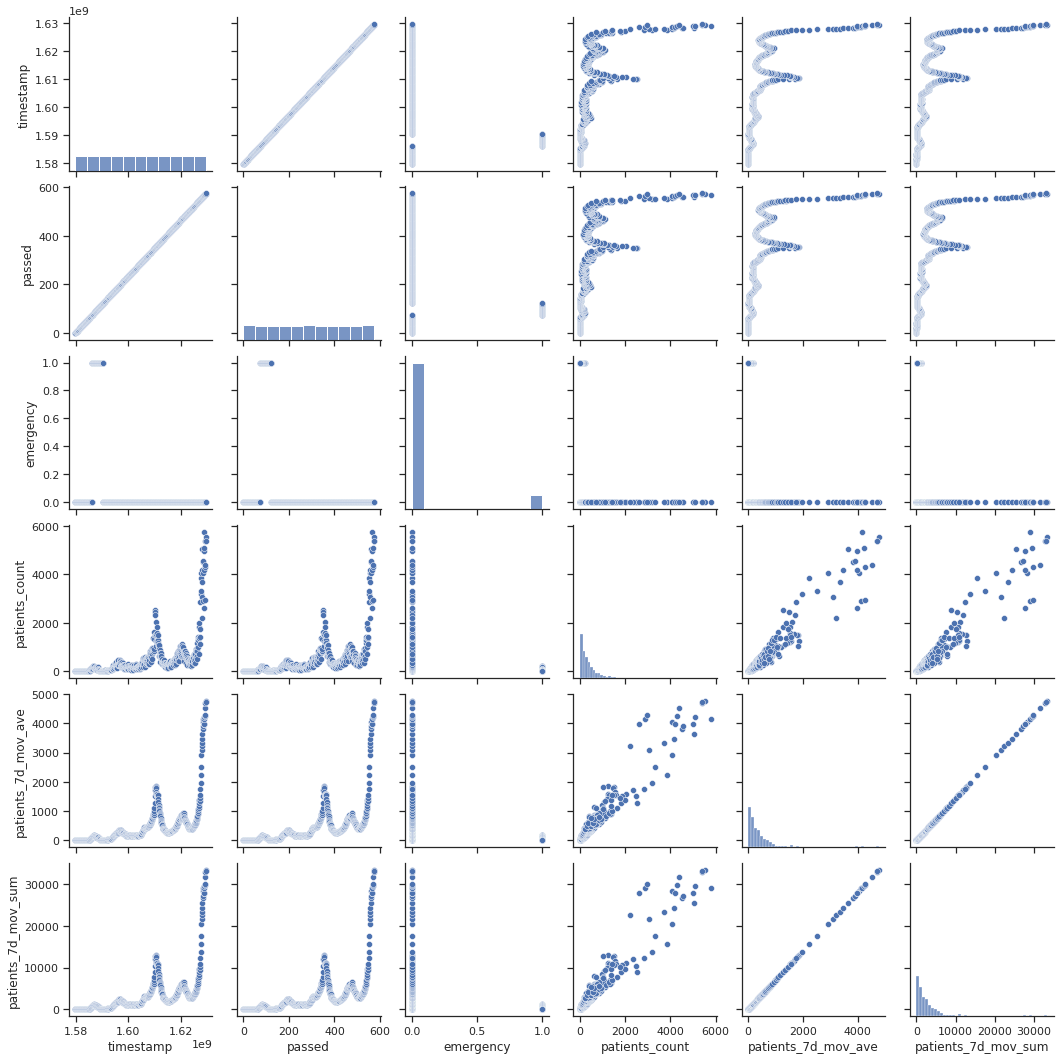

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.11
